# import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Trying different models to find the best fit

                    Quality  Moisture   Total Yield
Linear Regression  0.515084  0.038862  50734.077418
Random Forest      0.311517  0.026166  18522.667467
Gradient Boosting  0.456453  0.032742  27344.261047


<Figure size 1000x600 with 0 Axes>

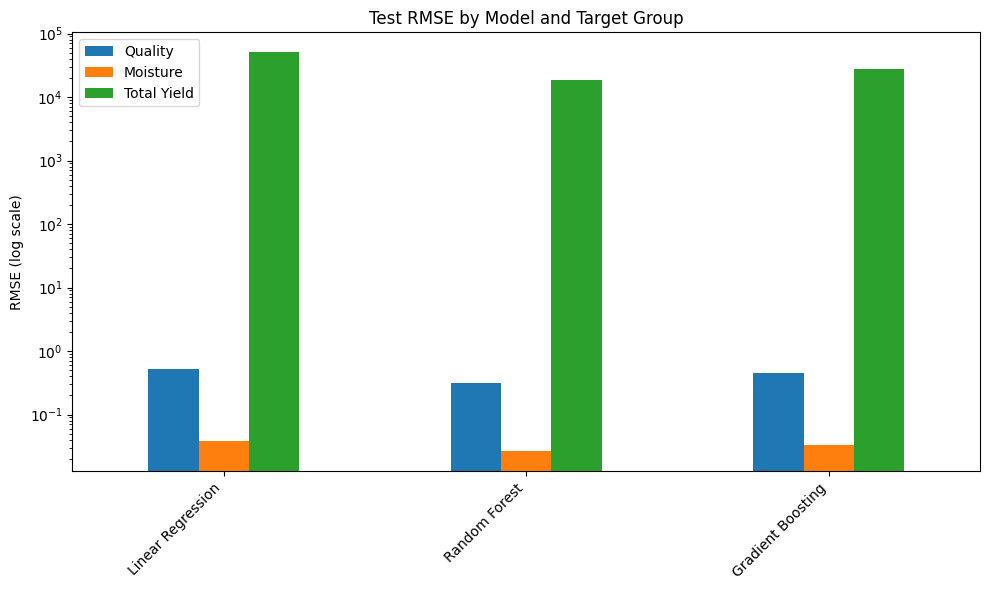

In [4]:
# load dataset
df = pd.read_csv('final_coffee_no_area_year.csv')
df = df.drop(["Total Cup Points", "Category One Defects", "Quakers", "Category Two Defects"], axis=1)

# feature columns (inputs)
feature_cols = [
    'Annual precipitation', 
    'Temperature Change on Land', 
    'Altitude',
    'Processing Method_Natural / Dry', 
    'Processing Method_Other',
    'Processing Method_Pulped natural / honey',
    'Processing Method_Semi-washed / Semi-pulped',
    'Processing Method_Washed / Wet', 
    'Processing Method_Anaerobico 1000h',
    'Processing Method_intrinsic cherry',
    'Processing Method_Double Anaerobic Washed',
    'Processing Method_Fermented in barrels with figs 4days',
    'Processing Method_Double Carbonic Maceration / Natural'
]

# targets
# - Quality scores (Aroma, Flavor, Aftertaste, Acidity, Body, Balance, Uniformity, Clean Cup, Sweetness, Cupper Points) on a 1–10 scale
# - Moisture (0–1 scale)
# - Total Yield (large-scale values)
target_cols = [col for col in df.columns if col not in feature_cols]

# create X (features) and y (targets)
X = df[feature_cols]
y = df[target_cols]

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# define our models
models = {
    'Linear Regression': MultiOutputRegressor(
        Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ])
    ),
    'Random Forest': MultiOutputRegressor(
        RandomForestRegressor(n_estimators=100, random_state=42)
    ),
    'Gradient Boosting': MultiOutputRegressor(
        GradientBoostingRegressor(n_estimators=100, random_state=42)
    )
}

# first 10 columns: Quality scores,
# 11th column: Moisture,
# 12th column: Total Yield)
quality_cols = target_cols[:10]
moisture_col = target_cols[10]
yield_col = target_cols[11]

# Evaluate each model on the test set separately for each target group
model_results = {}
for model_name, model in models.items():
    # train & fit
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # compute RMSE for Quality Group
    quality_rmse = np.sqrt(mean_squared_error(y_test[quality_cols], y_pred[:, :10]))
    # rmse for Moisture
    moisture_rmse = np.sqrt(mean_squared_error(y_test[moisture_col], y_pred[:, 10]))
    # rmse for Total Yield
    yield_rmse = np.sqrt(mean_squared_error(y_test[yield_col], y_pred[:, 11]))
    
    model_results[model_name] = [quality_rmse, moisture_rmse, yield_rmse]

# df for easier plotting
results_df = pd.DataFrame(model_results, index=['Quality', 'Moisture', 'Total Yield']).T
print(results_df)

plt.figure(figsize=(10, 6))
ax = results_df.plot(kind='bar', figsize=(10,6), logy=True)
ax.set_ylabel("RMSE (log scale)")
ax.set_title("Test RMSE by Model and Target Group")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Findint the best params for Random Forest

In [5]:
X = df[feature_cols]

# Define target groups:
# - Quality scores: values from 1 to 10
# - Moisture: values from 0 to 1
# - Total Yield: large-scale values
quality_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 
                'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points']
moisture_cols = ['Moisture']
yield_cols = ['Total Yield']

y_quality = df[quality_cols]
y_moisture = df[moisture_cols]
y_yield = df[yield_cols]

# Use a consistent train-test split
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

y_quality_train = y_quality.loc[train_idx]
y_quality_test = y_quality.loc[test_idx]

y_moisture_train = y_moisture.loc[train_idx]
y_moisture_test = y_moisture.loc[test_idx]

y_yield_train = y_yield.loc[train_idx]
y_yield_test = y_yield.loc[test_idx]


# Hyperparameter tuning for quality group - MultiOutputRegressor since we have 10 quality scores
rf_quality_base = RandomForestRegressor(random_state=42)
multi_rf_quality = MultiOutputRegressor(rf_quality_base)

# parameter grid for the underlying estimator (note the prefix 'estimator__')
param_grid_quality = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_leaf': [1, 2, 4]
}

grid_quality = GridSearchCV(multi_rf_quality, param_grid_quality, cv=3,
                            scoring='neg_mean_squared_error', n_jobs=-1)
grid_quality.fit(X_train, y_quality_train)
print("Best parameters for Quality Group:", grid_quality.best_params_)

best_quality_model = grid_quality.best_estimator_
y_quality_pred = best_quality_model.predict(X_test)
rmse_quality = np.sqrt(mean_squared_error(y_quality_test, y_quality_pred))
print("Quality Group RMSE:", rmse_quality)



# Hyperparameter tuning for moisture - Moisture is a single output
rf_moisture = RandomForestRegressor(random_state=42)
param_grid_single = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

grid_moisture = GridSearchCV(rf_moisture, param_grid_single, cv=3,
                             scoring='neg_mean_squared_error', n_jobs=-1)
grid_moisture.fit(X_train, y_moisture_train.values.ravel())
print("Best parameters for Moisture:", grid_moisture.best_params_)

best_moisture_model = grid_moisture.best_estimator_
y_moisture_pred = best_moisture_model.predict(X_test)
rmse_moisture = np.sqrt(mean_squared_error(y_moisture_test, y_moisture_pred))
print("Moisture RMSE:", rmse_moisture)

# Hyperparameter Tuning for Total Yield
rf_yield = RandomForestRegressor(random_state=42)
grid_yield = GridSearchCV(rf_yield, param_grid_single, cv=3,
                          scoring='neg_mean_squared_error', n_jobs=-1)
grid_yield.fit(X_train, y_yield_train.values.ravel())
print("Best parameters for Total Yield:", grid_yield.best_params_)

best_yield_model = grid_yield.best_estimator_
y_yield_pred = best_yield_model.predict(X_test)
rmse_yield = np.sqrt(mean_squared_error(y_yield_test, y_yield_pred))
print("Total Yield RMSE:", rmse_yield)


# average feature importances across all quality outputs
importances = np.array([est.feature_importances_ for est in best_quality_model.estimators_])
avg_importances = np.mean(importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances for Quality Group:")
print(feature_importance_df)


Best parameters for Quality Group: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 200}
Quality Group RMSE: 0.44437822403771593
Best parameters for Moisture: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
Moisture RMSE: 0.02618267098372356
Best parameters for Total Yield: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
Total Yield RMSE: 18517.017474732962

Feature Importances for Quality Group:
                                              Feature  Importance
2                                            Altitude    0.340969
0                                Annual precipitation    0.304361
1                          Temperature Change on Land    0.261518
7                      Processing Method_Washed / Wet    0.058019
3                     Processing Method_Natural / Dry    0.025511
6         Processing Method_Semi-washed / Semi-pulped    0.004562
4                             Processing Method_Other    0.003848
5

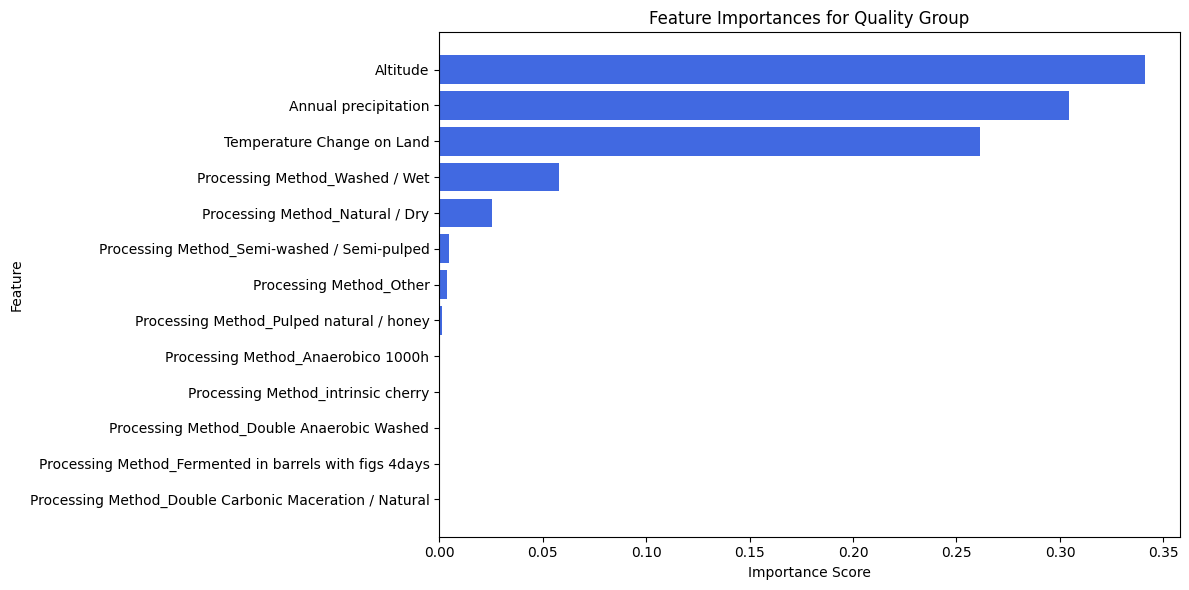

In [6]:
# Plot feature importance for the Quality Group
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='royalblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importances for Quality Group")
plt.gca().invert_yaxis()  # Invert to show the most important feature on top
plt.tight_layout()
plt.show()

### Fine tuned model

In [7]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_leaf': 1,
    'random_state': 42
}

# Train and evaluate quality group
rf_quality = MultiOutputRegressor(RandomForestRegressor(**rf_params))
rf_quality.fit(X_train, y_quality_train)
y_quality_pred = rf_quality.predict(X_test)
rmse_quality = np.sqrt(mean_squared_error(y_quality_test, y_quality_pred))
print("Quality Group RMSE:", rmse_quality)

# train and evaluate moisture
rf_moisture = RandomForestRegressor(**rf_params)
rf_moisture.fit(X_train, y_moisture_train.values.ravel())
y_moisture_pred = rf_moisture.predict(X_test)
rmse_moisture = np.sqrt(mean_squared_error(y_moisture_test, y_moisture_pred))
print("Moisture RMSE:", rmse_moisture)

# train and evaluate total yield
rf_yield = RandomForestRegressor(**rf_params)
rf_yield.fit(X_train, y_yield_train.values.ravel())
y_yield_pred = rf_yield.predict(X_test)
rmse_yield = np.sqrt(mean_squared_error(y_yield_test, y_yield_pred))
print("Total Yield RMSE:", rmse_yield)

# Feature importance for quality group
importances = np.array([est.feature_importances_ for est in rf_quality.estimators_])
avg_importances = np.mean(importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances for Quality Group:")
print(feature_importance_df)


Quality Group RMSE: 0.3115881745051029
Moisture RMSE: 0.02618267098372356
Total Yield RMSE: 18517.017474732962

Feature Importances for Quality Group:
                                              Feature  Importance
2                                            Altitude    0.343781
0                                Annual precipitation    0.253176
1                          Temperature Change on Land    0.217951
3                     Processing Method_Natural / Dry    0.085924
7                      Processing Method_Washed / Wet    0.068843
4                             Processing Method_Other    0.015011
6         Processing Method_Semi-washed / Semi-pulped    0.007684
10          Processing Method_Double Anaerobic Washed    0.003470
5            Processing Method_Pulped natural / honey    0.003051
9                  Processing Method_intrinsic cherry    0.000658
12  Processing Method_Double Carbonic Maceration /...    0.000412
8                  Processing Method_Anaerobico 1000h    

In [9]:
from sklearn.metrics import r2_score

# Calculate R² for Quality Group
r2_quality = r2_score(y_quality_test, y_quality_pred)
print(f"Quality Group R²: {r2_quality:.4f}")

# Calculate R² for Moisture
r2_moisture = r2_score(y_moisture_test, y_moisture_pred)
print(f"Moisture R²: {r2_moisture:.4f}")

# Calculate R² for Total Yield
r2_yield = r2_score(y_yield_test, y_yield_pred)
print(f"Total Yield R²: {r2_yield:.4f}")

# Create a summary DataFrame of evaluation metrics
evaluation_summary = pd.DataFrame({
    'Model': ['Quality Group', 'Moisture', 'Total Yield'],
    'RMSE': [rmse_quality, rmse_moisture, rmse_yield],
    'R²': [r2_quality, r2_moisture, r2_yield]
})

print("\nEvaluation Summary:")
print(evaluation_summary)

Quality Group R²: 0.6535
Moisture R²: 0.5780
Total Yield R²: 0.8810

Evaluation Summary:
           Model          RMSE        R²
0  Quality Group      0.311588  0.653514
1       Moisture      0.026183  0.577953
2    Total Yield  18517.017475  0.881025


In [8]:
import joblib

joblib.dump(rf_quality, "rf_quality_model.pkl")
joblib.dump(rf_moisture, "rf_moisture_model.pkl")
joblib.dump(rf_yield, "rf_yield_model.pkl")

print("Models saved successfully!")


Models saved successfully!
